# Libraries

In [1]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Data

In [27]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data_raw = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data = data_raw.copy()
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()
print(data.head(4).to_markdown())

# Split train-backtest
# ==============================================================================
n_backtest = 36*3  # Last 9 years are used for backtest
data_train = data[:-n_backtest]
data_backtest = data[-n_backtest:]

| datetime            |        y |
|:--------------------|---------:|
| 1991-07-01 00:00:00 | 0.429795 |
| 1991-08-01 00:00:00 | 0.400906 |
| 1991-09-01 00:00:00 | 0.432159 |
| 1991-10-01 00:00:00 | 0.492543 |


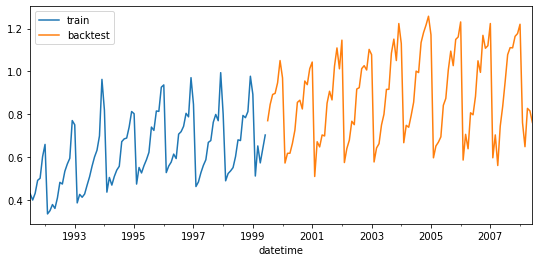

In [28]:
# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_backtest.plot(ax=ax, label='backtest')
ax.legend();

# Training predictions with backtesting_forecaster()

In [29]:
# Fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 15 
             )

forecaster.fit(y=data_train)

In [30]:
# Backtest train data. Require:
# forecaster already trained
# initial_train_size = None, refit = False
# if steps = 1, all predictions are t+1. If steps > 1 the data will be
# separated into folds
# ==============================================================================

metric, predictions_train = backtesting_forecaster(
                                forecaster = forecaster,
                                y          = data_train,
                                initial_train_size = None,
                                steps      = 1,
                                metric     = 'mean_squared_error',
                                refit      = False,
                                verbose    = False
                           )

print(f"Error de backtest: {metric}")
print(predictions_train.head(4).to_markdown())

Error de backtest: [0.00045087]
|                     |     pred |
|:--------------------|---------:|
| 1992-10-01 00:00:00 | 0.553134 |
| 1992-11-01 00:00:00 | 0.567766 |
| 1992-12-01 00:00:00 | 0.721389 |
| 1993-01-01 00:00:00 | 0.750997 |


The first 15 observations are not predicted because it is not possible to create the lag matrix


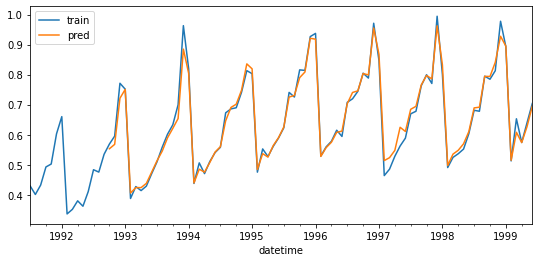

In [33]:
# Plot
# ==============================================================================
n_lags = max(forecaster.lags)

print(f"The first {n_lags} observations are not predicted because "\
      "it is not possible to create the lag matrix")

fig, ax = plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
predictions_train.plot(ax=ax, label='predictions')
ax.legend();

# Training predictions through the regressor

In [46]:
# Fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 15 
             )

forecaster.fit(y=data_train)

In [47]:
# Create lags matrix
# ==============================================================================
X, y = forecaster.create_train_X_y(
            y = data_train, 
            exog = None
       )

In [48]:
# Predict through the regressor
# ==============================================================================
forecaster.regressor.predict(X)[:4]

array([0.55313393, 0.56776596, 0.72138941, 0.75099737])